In [1]:
from defs_NNI import *
import glob

starting_trees = glob.glob("./training_data_all/**/real_msa.phy_phyml_tree_bionj.txt", recursive=True)
len(starting_trees)

4200

In [ ]:
newick_str = starting_trees[-1]
tree = Tree(newick_str, format=1)
init_recursive_features(tree)
#tree.show()
tree

In [ ]:
# FEATURES OF STARTING TREE
start_tree = extract_tree_features(tree)

In [ ]:
start_tree

In [ ]:
nni_trees, leaves, bls = perform_nni(tree)

In [ ]:
len(nni_trees), len(leaves), len(bls)

In [ ]:
bls[0][0].maxBL

In [ ]:
df = extract_nni_features(nni_trees, leaves, bls)
df

In [ ]:
newick_str = starting_trees[-1]
print (newick_str)
ds_path = newick_str.split("/")
ds_path = ds_path[:3]
ds_path = "/".join(ds_path + [""])
print (ds_path)
optimize = nni_trees[0]
optimize

In [ ]:
# OPTIMIZE TREE
stats_filepath = ds_path + PHYML_STATS_FILENAME.format('bionj')
params_dict = (parse_phyml_stats_output(None, stats_filepath))

MSA_PHYLIP_FILENAME = "real_msa.phy"
PHYML_STATS_FILENAME = MSA_PHYLIP_FILENAME + "_phyml_stats_{0}.txt"
PHYML_TREE_FILENAME = MSA_PHYLIP_FILENAME + "_phyml_tree_{0}.txt"
ROOTLIKE_NAME = "ROOT_LIKE"

SEP = "/"

orig_msa_file = ds_path + MSA_PHYLIP_FILENAME
stats_filepath = ds_path + PHYML_STATS_FILENAME.format('bionj')
t_orig = get_tree(ds_path, orig_msa_file)
t_orig.get_tree_root().name = ROOTLIKE_NAME

#first, copy msa file to memory and save it:
msa_rampath = "/dev/shm/tm p" + ds_path.split(SEP)[-2] #  to be on the safe side (even though other processes shouldn't be able to access it)
with open(orig_msa_file) as fpr:
    msa_str = fpr.read()
try:
    with open(msa_rampath, "w") as fpw:
        fpw.write(msa_str)  # don't write the msa string to a variable (or write and release it)
    msa_str = ''

    params_dict = (parse_phyml_stats_output(None, stats_filepath))
    freq, rates, pinv, alpha = [params_dict["fA"], params_dict["fC"], params_dict["fG"], params_dict["fT"]], [params_dict["subAC"], params_dict["subAG"], params_dict["subAT"], params_dict["subCG"],params_dict["subCT"], params_dict["subGT"]], params_dict["pInv"], params_dict["gamma"]
    df = pd.DataFrame()


    nnis, a, b = perform_nni(tree)
    print (len(nnis), params_dict["ll"])

    ll_rearrs = []
    n = 1
    for nni in nnis:
        newick_str = nni.write(format=1)
        ll_rearr, rtime = call_raxml_mem(newick_str, msa_rampath, rates, pinv, alpha, freq, n, ds_path)
        print (ll_rearr, rtime)
        ll_rearrs.append(ll_rearr)
        n+=1
    
    optimized_trees = glob.glob(f"{ds_path}NNI/*")
    
    # starting_tree_features = extract_tree_features(tree)
    # nni_trees, nni_leaves, nni_branch_lengths = perform_nni(tree)
    # nni_features_df = extract_nni_features(tree, nni_trees, nni_leaves, nni_branch_lengths, ds_path)

    # # Convert to DataFrame and save
    # df = pd.DataFrame([starting_tree_features])
    # # df.to_csv("starting_tree_features.csv", index=False)
    # nni_features_df = nni_features_df.merge(df, how='cross')
    # nni_features_df["ll_orig"] = params_dict["ll"]
    # nni_features_df["ll_nni"] = ll_rearrs
    # nni_features_df.to_csv(f"{ds_path}nni_features.csv", index=False)
except Exception as e:
    print('could not complete the all_SPR function on dataset:', dataset_path, '\nError message:')
    print(e)
    exit()
finally:
    os.remove(msa_rampath)

In [ ]:
ll_rearrs, params_dict["ll"]
greater = 0
for ll in ll_rearrs:
    # if (float(params_dict["ll"]) - float(ll) > 0):
    #     greater += 1
    print ((float(ll) - float(params_dict["ll"])) / float(params_dict["ll"]))
print (greater)

In [ ]:
params_dict

In [ ]:
optimized_trees = ["{}NNI/optimized_{}.raxml.bestTree".format(ds_path, i+1) for i in range(len(nnis))]

for t in optimized_trees:
    optimize = Tree(t, format=1)
    init_recursive_features(optimize)

features_after = []
for i, (opt_tree, bl_info) in enumerate(zip(optimized_trees, bls)):
    opt = Tree(opt_tree, format=1)
    init_recursive_features(opt)
    bl_subtree1_after = opt.search_nodes(name=bl_info[0].name)[0].dist
    bl_subtree2_after = opt.search_nodes(name=bl_info[2].name)[0].dist      

    longest_branch_subtree1_after = opt.search_nodes(name=bl_info[0].name)[0].maxBL #max(node.dist for node in nni_tree.search_nodes(name=bl_info[0].name)[0].traverse())
    longest_branch_subtree2_after = opt.search_nodes(name=bl_info[2].name)[0].maxBL #max(node.dist for node in nni_tree.search_nodes(name=bl_info[2].name)[0].traverse())
    
    features_after.append({
        "idx": i,
        "S1":bl_info[0].name,
        "S2":bl_info[2].name,
        "bl_S1_a": bl_subtree1_after,
        "bl_S2_a": bl_subtree2_after,
        "maxBL_S1_a": longest_branch_subtree1_after,
        "maxBL_S2_a": longest_branch_subtree2_after,
    })
features_after = pd.DataFrame(features_after)
features_after

In [ ]:
df_copy = df.merge(features_after, on=["idx", "S1", "S2"])
df_copy["ll_rearrs"] = ll_rearrs
df_copy["ll_orig"] = params_dict["ll"]
df_copy["ntaxa"] = start_tree["ntaxa"]
df_copy["tbl"] = start_tree["tbl"]
df_copy["maxBL"] = start_tree["maxBL"]

In [ ]:
df_copy

In [ ]:
training_csvs = glob.glob("./training_data_all/**/", recursive=False)

In [ ]:
len(training_csvs)

In [ ]:
import statistics as stats
counter = 0
num_samples = []
for t in training_csvs:
    if (os.path.exists(f"{t}dataset.csv")):
        counter += 1
        # print (t)
        with open(f"{t}dataset.csv") as f:
            lines = f.readlines()
            num_samples.append(len(lines)-1)
print ("Number of folders: ", len(num_samples))
print ("Min/Max number of samples: {}, {}".format(min(num_samples), max(num_samples)))
print ("Median number of samples: ", stats.median(num_samples))
print ("Total number of samples: ", sum(num_samples))

In [ ]:
from defs_NNI import *
import glob

def all_nni(newick_file):
	ds_path = newick_file.split("/")
	ds_path = ds_path[:3]
	ds_path = "/".join(ds_path + [""])

	orig_msa_file = ds_path + MSA_PHYLIP_FILENAME
	stats_filepath = ds_path + PHYML_STATS_FILENAME.format('bionj')
	t_orig = get_tree(ds_path, orig_msa_file)
	t_orig.get_tree_root().name = ROOTLIKE_NAME
    
	nwk_str = t_orig.write(format=1)
	
	tree = Tree(nwk_str, format=1)
	init_recursive_features(tree)
	
	# FEATURES OF STARTING TREE
	start_tree = extract_tree_features(tree)
	
	nni_trees, leaves, bls = perform_nni(tree)
	
	df = extract_nni_features(nni_trees, leaves, bls)
	
	
	optimize = nni_trees[0]
	

	

	#first, copy msa file to memory and save it:
	msa_rampath = "/dev/shm/tm p" + ds_path.split(SEP)[-2] #  to be on the safe side (even though other processes shouldn't be able to access it)
	with open(orig_msa_file) as fpr:
		msa_str = fpr.read()
	try:
		with open(msa_rampath, "w") as fpw:
			fpw.write(msa_str)  # don't write the msa string to a variable (or write and release it)
		msa_str = ''

		params_dict = (parse_phyml_stats_output(None, stats_filepath))
		freq, rates, pinv, alpha = [params_dict["fA"], params_dict["fC"], params_dict["fG"], params_dict["fT"]], [params_dict["subAC"], params_dict["subAG"], params_dict["subAT"], params_dict["subCG"],params_dict["subCT"], params_dict["subGT"]], params_dict["pInv"], params_dict["gamma"]
		# df = pd.DataFrame()


		nnis, a, b = perform_nni(tree)
		# print (len(nnis), params_dict["ll"])

		ll_rearrs = []
		n = 1
		for nni in nnis:
			newick_str = nni.write(format=1)
			ll_rearr, rtime = call_raxml_mem(newick_str, msa_rampath, rates, pinv, alpha, freq, n, ds_path)
			# print (ll_rearr, rtime)
			n+=1
			if (rtime == "no ll opt_no time"):
				continue
			ll_rearrs.append(ll_rearr)
			

		# optimized_trees = glob.glob(f"{ds_path}NNI/*")

		# starting_tree_features = extract_tree_features(tree)
		# nni_trees, nni_leaves, nni_branch_lengths = perform_nni(tree)
		# nni_features_df = extract_nni_features(tree, nni_trees, nni_leaves, nni_branch_lengths, ds_path)

		# # Convert to DataFrame and save
		# df = pd.DataFrame([starting_tree_features])
		# # df.to_csv("starting_tree_features.csv", index=False)
		# nni_features_df = nni_features_df.merge(df, how='cross')
		# nni_features_df["ll_orig"] = params_dict["ll"]
		# nni_features_df["ll_nni"] = ll_rearrs
		# nni_features_df.to_csv(f"{ds_path}nni_features.csv", index=False)
	except Exception as e:
		print('could not complete the all_SPR function on dataset:', dataset_path, '\nError message:')
		print(e)
		exit()
	finally:
		os.remove(msa_rampath)

		
	optimized_trees = ["{}NNI/optimized_{}.raxml.bestTree".format(ds_path, i+1) for i in range(len(nnis))]
	for t in optimized_trees:
		if (os.path.exists(t)):
			optimize = Tree(t, format=1)
			init_recursive_features(optimize)

	features_after = []
	for i, (opt_tree, bl_info) in enumerate(zip(optimized_trees, bls)):
		if (os.path.exists(opt_tree)):
			opt = Tree(opt_tree, format=1)
			init_recursive_features(opt)
			bl_subtree1_after = opt.search_nodes(name=bl_info[0].name)[0].dist
			bl_subtree2_after = opt.search_nodes(name=bl_info[2].name)[0].dist      

			longest_branch_subtree1_after = opt.search_nodes(name=bl_info[0].name)[0].maxBL #max(node.dist for node in nni_tree.search_nodes(name=bl_info[0].name)[0].traverse())
			longest_branch_subtree2_after = opt.search_nodes(name=bl_info[2].name)[0].maxBL #max(node.dist for node in nni_tree.search_nodes(name=bl_info[2].name)[0].traverse())

			features_after.append({
				"idx": i,
				"S1":bl_info[0].name,
				"S2":bl_info[2].name,
				"bl_S1_a": bl_subtree1_after,
				"bl_S2_a": bl_subtree2_after,
				"maxBL_S1_a": longest_branch_subtree1_after,
				"maxBL_S2_a": longest_branch_subtree2_after,
			})
	features_after = pd.DataFrame(features_after)
	
	df_copy = df.merge(features_after, on=["idx", "S1", "S2"])
	df_copy["ll_rearrs"] = ll_rearrs
	df_copy["ll_orig"] = params_dict["ll"]
	df_copy["ntaxa"] = start_tree["ntaxa"]
	df_copy["tbl"] = start_tree["tbl"]
	df_copy["maxBL"] = start_tree["maxBL"]
	
	df_copy["ll_rearrs"] = df_copy["ll_rearrs"].astype(float)
	df_copy["ll_orig"] = df_copy["ll_orig"].astype(float)
	df_copy["target"] = (df_copy["ll_rearrs"] - df_copy["ll_orig"]) / df_copy["ll_orig"]
	
	df_copy.to_csv('{}dataset.csv'.format(ds_path), index=False)

def extractFeatures(dataset_path):
	# Executes all processes for a given dataset sequentially.
	print("START extractFeatures:", dataset_path, "at", datetime.datetime.now())
	if os.path.exists(dataset_path):
		all_nni(dataset_path)
	print("DONE extractFeatures:", dataset_path, "at", datetime.datetime.now())
	
if __name__ == "__main__":
	starting_trees = glob.glob("./validation_data/**/real_msa.phy_phyml_tree_bionj.txt", recursive=True)
	# for s in starting_trees:
	# 	extractFeatures(s)
	with ProcessPoolExecutor(max_workers=min(4, os.cpu_count()-2)) as executor: #adjust max workers accordingly
		executor.map(extractFeatures, starting_trees)



In [2]:
len(starting_trees)

4200

In [3]:
dataset_all = pd.DataFrame()
starting_trees
counter = 0
for s in starting_trees:
    
    ds_path = s.split("/")
    ds_path = ds_path[:3]
    ds_path = "/".join(ds_path)
    dataset = ds_path + "/dataset.csv"
    if (os.path.exists(dataset)):
        dataset = pd.read_csv(dataset)
        dataset_all = pd.concat([dataset.drop(columns=["idx", "S1", "S2", "ll_rearrs", "ll_orig", "maxBL_S2_b", "maxBL_S2_a", "ntaxa_S1", "ntaxa_S2", "cumBL_S1", "cumBL_S2","maxBL_S1_b", "maxBL_S1_a"]), dataset_all], ignore_index=True)
        counter += 1
    # , "maxBL_S1_b", "maxBL_S1_a", "maxBL_S2_b", "maxBL_S2_a", 
print (counter)
dataset_all

4196


,bl_S1_b,bl_S2_b,bl_S1_a,bl_S2_a,ntaxa,tbl,maxBL,target
0,1.321200e-02,0.001547,0.013212,0.001547,37,1.830373,0.130364,7.349442e-07
1,2.888000e-05,0.001547,0.000826,0.001546,37,1.830373,0.130364,6.778560e-07
2,9.000000e-08,0.001588,0.000001,0.003085,37,1.830373,0.130364,2.062569e-04
3,1.000000e-08,0.001588,0.000001,0.003084,37,1.830373,0.130364,2.063139e-04
4,1.591740e-03,0.104397,0.009683,0.101092,37,1.830373,0.130364,2.330472e-03
...,...,...,...,...,...,...,...,...
211696,5.379480e-03,0.037287,0.005370,0.041850,48,1.365554,0.184093,3.393520e-04
211697,6.534650e-03,0.014831,0.002517,0.038518,48,1.365554,0.184093,2.080442e-03
211698,3.728710e-02,0.014831,0.039269,0.040252,48,1.365554,0.184093,2.430963e-03
211699,2.536060e-02,0.001945,0.189875,0.001923,48,1.365554,0.184093,3.730175e-02


In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load dataset (Replace with your actual dataset)
df = dataset_all.copy()

# Define features (X) and target variable (y)
X = df.drop(columns=["target"])  # Replace with actual target column name
y = df["target"]

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=200, max_features=0.33, max_depth=None, min_samples_split=10, n_jobs=-1, random_state=42)

#################################################################################
# Define K-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV

# # Perform Cross-Validation
# cv_scores = cross_val_score(rf_regressor, X, y, cv=kf, scoring="r2")  # R² for regression

# print("Cross-Validation Scores:", cv_scores)
# print("Mean R² Score:", np.mean(cv_scores))
# print("Standard Deviation of R²:", np.std(cv_scores))
#################################################################################

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mspe = mean_squared_error(y_test, y_pred) / (np.mean(y_test) ** 2)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
# print(f"Mean Squared Percentage Error: {mspe:.6f}")
print(f"R² Score: {r2:.4f}")


print(f"Train R²: {rf_regressor.score(X_train, y_train):.4f}")
print(f"Test R²: {rf_regressor.score(X_test, y_test):.4f}")

# n_estimators = 300
# Mean Squared Error: 1.0131278127287636e-05
# R² Score: 0.7201
# Train R²: 0.6674
# Test R²: 0.7201
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# Calculate Spearman Correlation
corr, p_value = spearmanr(y_test, y_pred)

print(f"Spearman Correlation: {corr:.4f}")
print(f"P-value: {p_value}")

# print (np.var(y_test), np.var(y_pred))

Mean Squared Error: 9.943834454250411e-06
R² Score: 0.7253
Train R²: 0.6607
Test R²: 0.7253
Spearman Correlation: 0.8593
P-value: 0.0


In [ ]:
dataset_all["target"].describe()

Spearman Correlation: 0.8593
P-value: 0.0


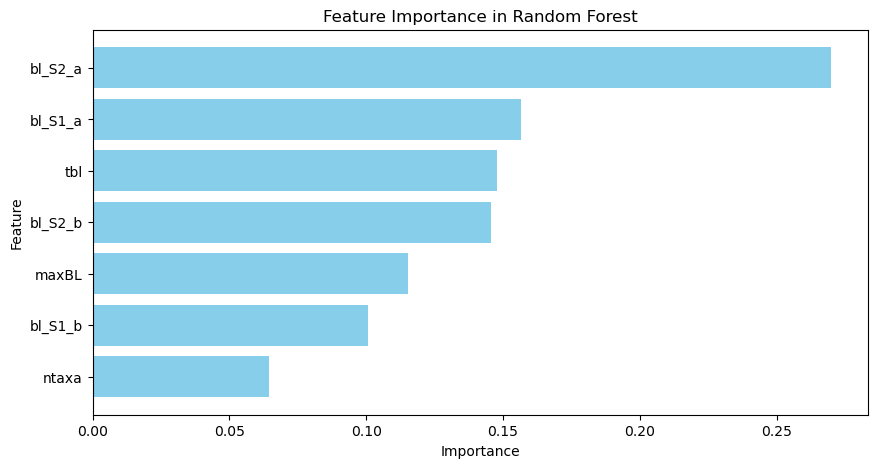

In [33]:
import matplotlib.pyplot as plt

feature_importance = rf_regressor.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


In [7]:
validation_trees = glob.glob("./validation_data/**/real_msa.phy_phyml_tree_bionj.txt", recursive=True)
dataset_val = pd.DataFrame()
counter = 0
for s in validation_trees:
    ds_path = s.split("/")
    ds_path = ds_path[:3]
    ds_path = "/".join(ds_path)
    dataset = ds_path + "/dataset.csv"
    # print (dataset)
    if (os.path.exists(dataset)):
        dataset = pd.read_csv(dataset)
        dataset_val = pd.concat([dataset.drop(columns=["idx", "S1", "S2", "ll_rearrs", "ll_orig", "maxBL_S2_b", "maxBL_S2_a", "ntaxa_S1", "ntaxa_S2", "cumBL_S1", "cumBL_S2","maxBL_S1_b", "maxBL_S1_a"]), dataset_val], ignore_index=True)
        counter += 1
    # , "maxBL_S1_b", "maxBL_S1_a", "maxBL_S2_b", "maxBL_S2_a", 
print (counter)
dataset_val

1000


,bl_S1_b,bl_S2_b,bl_S1_a,bl_S2_a,ntaxa,tbl,maxBL,target
0,1.539030,0.486479,1.769727,0.482622,7,6.490272,1.53903,5.802704e-04
1,0.847436,0.486479,1.148956,0.463723,7,6.490272,1.53903,5.865893e-04
2,0.380684,0.614733,0.444324,0.652530,7,6.490272,1.53903,7.654636e-04
3,0.486479,0.614733,0.640988,0.670205,7,6.490272,1.53903,8.023290e-04
4,0.614733,1.200720,0.614573,1.200877,7,6.490272,1.53903,-3.096269e-07
...,...,...,...,...,...,...,...,...
49034,0.200589,0.025435,0.222172,0.042901,9,4.946793,1.66193,1.306415e-03
49035,0.025435,0.203986,0.017569,0.304247,9,4.946793,1.66193,3.336654e-04
49036,0.056055,0.203986,0.056239,0.304729,9,4.946793,1.66193,3.520271e-04
49037,0.101642,1.661930,0.102586,2.117078,9,4.946793,1.66193,7.277439e-04


In [36]:
X_test_val = dataset_val.drop(columns=["target"])
y_test_val = dataset_val["target"]

y_pred_val = rf_regressor.predict(X_test_val)

mse = mean_squared_error(y_test_val, y_pred_val)
variance_y = np.var(y_test_val)
r2 = r2_score(y_test_val, y_pred_val)




# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
# print(f"Mean Squared Percentage Error: {mspe:.6f}")
print(f"R² Score: {r2:.4f}")


# print(f"Train R²: {rf_regressor.score(X_train, y_train):.4f}")
# print(f"Test R²: {rf_regressor.score(X_test, y_test):.4f}")

corr, p_value = spearmanr(y_test_val, y_pred_val)

print(f"Spearman Correlation: {corr:.4f}")

# # Print evaluation metrics
# print(f"MSE: {mse}, Variance of y_test: {variance_y}")
# # print(f"Mean Squared Error: {mse}")
# print(f"R² Score: {r2:.4f}")

Mean Squared Error: 6.650546541653115e-06
R² Score: 0.2246
Spearman Correlation: 0.6940


In [37]:
y_mean_pred = np.full_like(y_test, np.mean(y_test))  # Baseline: Predict mean of y_test
baseline_mse = mean_squared_error(y_test, y_mean_pred)

print(f"Baseline MSE: {baseline_mse:.6e}")  # Scientific notation for small numbers
print(f"Model MSE: {mse:.6e}")

if mse > baseline_mse:
    print("⚠️ Model is worse than predicting the mean!")

Baseline MSE: 3.619949e-05
Model MSE: 6.650547e-06


In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring="r2")
print("Mean Cross-Validation R²:", np.mean(cv_scores))

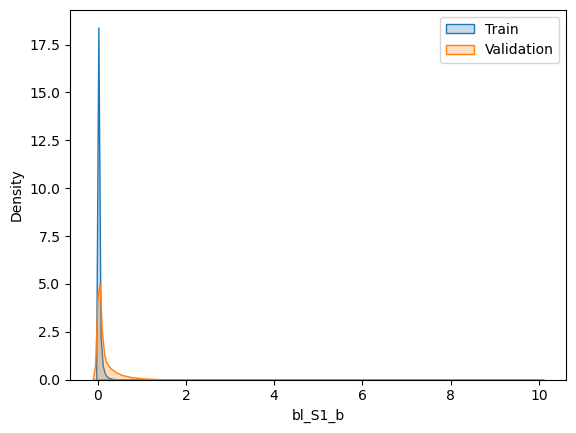

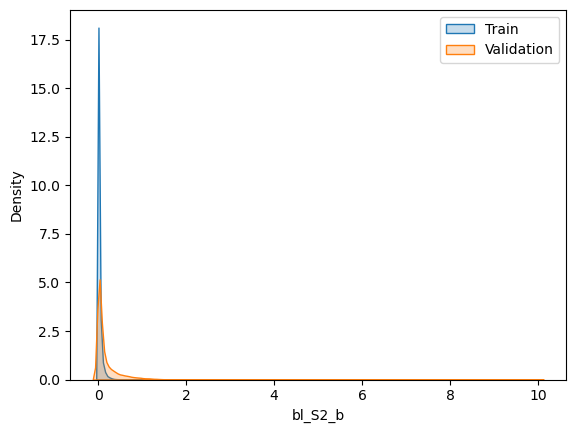

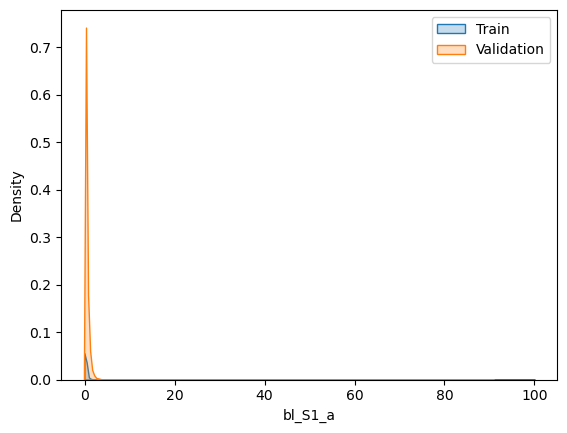

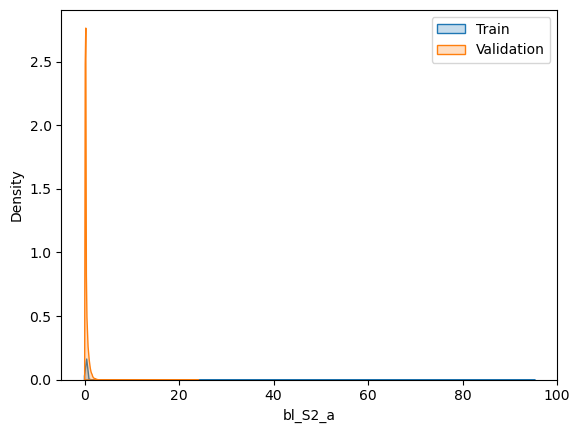

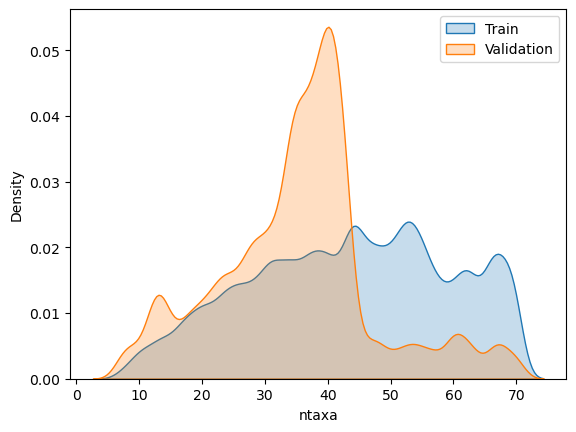

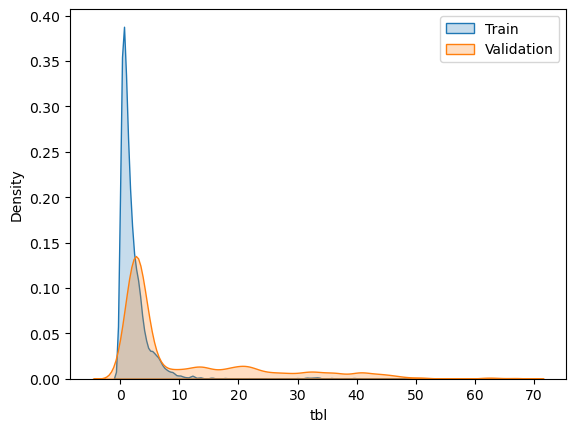

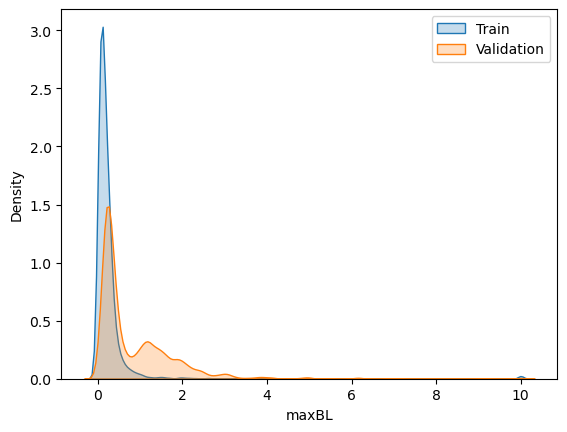

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
for col in X_train.columns:
    sns.kdeplot(X_train[col], label="Train", fill=True)
    sns.kdeplot(X_test_val[col], label="Validation", fill=True)
    plt.legend()
    plt.show()

In [55]:
all_moves = pd.read_csv("learning_all_moves_step1.csv")
print(all_moves.shape)
print(all_moves.loc[all_moves["d_ll_merged"].isna()].shape)
all_moves.loc[all_moves["d_ll_merged"].isna()].head()
all_moves

(39410, 35)
(1156, 35)


,Unnamed: 0,Unnamed: 0.1_prune,Unnamed: 0_prune,path,prune_name,rgft_name,time_prune,ll,orig_ds_ll,d_ll_prune,...,num_taxa_prune_rgft,tbl_pruned_rgft,longest_pruned_rgft,num_taxa_rgft_rgft,tbl_remaining_rgft,longest_remaining_rgft,topology_dist_between_rgft,tbl_dist_between_rgft,res_tree_edge_length_rgft,d_ll_merged
0,0,2,"1,0",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp011,N1,0.014,-1948.5886,-1948.5868,-0.001749,...,12.0,0.564830,0.015183,1.0,0.000000,0.000000,3.0,0.012684,0.003485,-0.001749
1,1,3,"1,1",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp011,Sp009,0.024,-1948.5886,-1948.5868,-0.001752,...,1.0,0.015183,0.015183,12.0,0.549647,0.327207,3.0,0.009469,0.003485,-0.001752
2,2,4,"1,2",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp011,N4,no ll opt_no time,NaN,-1948.5868,NaN,...,6.0,0.546931,0.327207,7.0,0.017899,0.015183,4.0,0.056545,0.003485,NaN
3,3,5,"1,3",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp011,Sp010,no ll opt_no time,NaN,-1948.5868,NaN,...,1.0,0.002716,0.002716,12.0,0.562114,0.327207,4.0,0.015400,0.003485,NaN
4,4,6,"1,4",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp011,N6,no ll opt_no time,NaN,-1948.5868,NaN,...,5.0,0.030744,0.327207,8.0,0.534086,0.327207,5.0,0.077839,0.003485,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39405,39405,43415,"64,58",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp030,N59,0.027,-10018.6455,-10018.6430,-0.002142,...,32.0,2.729367,0.001198,1.0,0.000000,0.000000,3.0,0.002398,0.002398,-0.002142
39406,39406,43416,"64,59",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp030,Sp029,0.082,-10174.0870,-10018.6430,-155.444060,...,1.0,0.135688,0.135688,32.0,2.593679,0.169363,6.0,0.271428,0.002398,-155.444060
39407,39407,43417,"64,60",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp030,Sp004,0.026,-10174.0870,-10018.6430,-155.443600,...,1.0,0.058257,0.058257,32.0,2.671110,0.169363,6.0,0.193997,0.002398,-155.443600
39408,39408,43418,"64,61",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp030,Sp031,0.032,-10018.6450,-10018.6430,-0.001954,...,1.0,0.001198,0.001198,32.0,2.728169,0.169363,4.0,0.003595,0.002398,-0.001954


In [57]:
all_moves = all_moves.dropna()
all_moves.loc[all_moves["time_prune"]=="no ll opt_no time"]

,Unnamed: 0,Unnamed: 0.1_prune,Unnamed: 0_prune,path,prune_name,rgft_name,time_prune,ll,orig_ds_ll,d_ll_prune,...,num_taxa_prune_rgft,tbl_pruned_rgft,longest_pruned_rgft,num_taxa_rgft_rgft,tbl_remaining_rgft,longest_remaining_rgft,topology_dist_between_rgft,tbl_dist_between_rgft,res_tree_edge_length_rgft,d_ll_merged
156,156,212,"12,11",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp005,N16,no ll opt_no time,-1948.5868,-1948.5868,0.000062,...,12.0,5.683146e-01,1.856400e-03,1.0,0.000000,0.000000,4.0,2.200000e-07,1.000000e-08,0.000062
161,161,217,"12,16",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp005,Sp001,no ll opt_no time,-1948.5868,-1948.5868,0.000062,...,1.0,1.000000e-08,1.000000e-08,12.0,0.568315,0.327207,5.0,2.300000e-07,1.000000e-08,0.000062
219,219,275,"15,11",/home/ubuntu/cs199/osfFiles/calibration_testin...,N16,Sp005,no ll opt_no time,-1948.5868,-1948.5868,0.000062,...,1.0,1.000000e-08,1.000000e-08,11.0,0.566458,0.327207,3.0,2.200000e-07,1.100000e-07,0.000062
240,240,296,"16,11",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp004,Sp005,no ll opt_no time,-1948.5868,-1948.5868,0.000008,...,1.0,1.000000e-08,1.000000e-08,12.0,0.566452,0.327207,4.0,1.862480e-03,1.862370e-03,0.000008
241,241,297,"16,12",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp004,N16,no ll opt_no time,-1948.5868,-1948.5868,0.000008,...,12.0,5.664523e-01,1.856400e-03,1.0,0.000000,0.000000,3.0,1.862480e-03,1.862370e-03,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35544,35544,39155,"49,45",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp023,Sp024,no ll opt_no time,-1870.6149,-1870.6149,0.000018,...,1.0,1.000000e-08,1.000000e-08,25.0,0.321362,0.086572,4.0,3.000000e-08,1.000000e-08,0.000018
35545,35545,39156,"49,46",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp023,Sp010,no ll opt_no time,-1870.6149,-1870.6149,0.000018,...,1.0,2.000000e-08,2.000000e-08,25.0,0.321362,0.086572,3.0,2.000000e-08,1.000000e-08,0.000018
35591,35591,39202,"50,43",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp010,N44,no ll opt_no time,-1870.6149,-1870.6149,0.000018,...,25.0,3.213619e-01,2.000000e-08,1.0,0.000000,0.000000,3.0,2.000000e-08,1.000000e-08,0.000018
35593,35593,39204,"50,45",/home/ubuntu/cs199/osfFiles/calibration_testin...,Sp010,Sp024,no ll opt_no time,-1870.6149,-1870.6149,0.000018,...,1.0,1.000000e-08,1.000000e-08,25.0,0.321362,0.086572,4.0,3.000000e-08,1.000000e-08,0.000018
